In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
from xgboost import XGBClassifier
import joblib

In [2]:
# Cambia esta ruta por la ruta local de tu archivo
file_path = "Data/url_phishing_data.csv"
df = pd.read_csv(file_path)
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.progarchives.com/album.asp?id=61737,46,20,zero,3,zero,0,1,0,0,...,1,one,0,627,6678,78526,0,0,5,phishing
1,http://signin.eday.co.uk.ws.edayisapi.dllsign....,128,120,0,10,0,0,0,0,0,...,1,zero,0,300,65,0,0,1,0,phishing
2,http://www.avevaconstruction.com/blesstool/ima...,52,25,0,3,0,0,0,0,0,...,1,zero,0,119,1707,0,0,1,0,phishing
3,http://www.jp519.com/,21,13,0,2,0,0,0,0,0,...,1,one,0,130,1331,0,0,0,0,legitimate
4,https://www.velocidrone.com/,28,19,0,2,0,0,0,0,0,...,0,zero,0,164,1662,312044,0,0,4,legitimate


In [3]:
df.describe()

,length_url,length_hostname,nb_dots,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,...,right_clic,empty_title,domain_in_title,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.0,11481.000000,11481.000000,11481.000000,...,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,1.148100e+04,11481.000000,11481.000000,11481.000000
mean,61.203902,21.129344,2.496298,0.022124,0.140928,0.168975,0.0,0.299364,0.334117,0.006707,...,0.001394,0.125425,0.773713,0.074122,492.388468,4059.613884,8.630862e+05,0.019598,0.535493,3.190837
std,56.795786,10.633279,1.421589,0.155721,0.365781,0.871249,0.0,1.040306,1.165724,0.081623,...,0.037307,0.331214,0.418445,0.261981,811.349827,3110.854830,2.000251e+06,0.138619,0.498760,2.531696
min,13.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,85.000000,966.000000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,246.000000,4003.000000,2.187000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,452.000000,7006.000000,3.733190e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,24.000000,4.000000,3.000000,19.000000,0.0,19.000000,18.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12873.000000,1.076799e+07,1.000000,1.000000,10.000000


In [4]:
# Revisar columnas con valores tipo texto (como "zero", "one") y convertir a número
# Primero vemos cuáles no son numéricas
non_numeric = df.select_dtypes(include='object').columns
print("Columnas no numéricas:", non_numeric)

Columnas no numéricas: Index(['url', 'ip', 'nb_hyphens', 'domain_with_copyright', 'status'], dtype='object')


In [5]:
for col in non_numeric:
  print(df[col].unique())

['http://www.progarchives.com/album.asp?id=61737'
 'http://signin.eday.co.uk.ws.edayisapi.dllsign.inusingsslpuseridcopartnerid2siteid.zdfxx949xyss1pnbh0soabfdzgdh2kppnu.reippl.com/'
 'http://www.avevaconstruction.com/blesstool/image.htm' ...
 'https://sites.google.com/site/ilyasdxih'
 'http://iceage.wikia.com/wiki/Ice_Age:_Collision_Course'
 'http://www.mousebreaker.com/games/clicker']
['zero' '0' '1' 'one']
['zero' '0' '1' '2' '5' '7' '4' '3' 'one' '8' '9' '6' '17' '11' '14' '24'
 '10' '13' '15' '19' '18' '16' '20' '26' '12' '32' '23']
['one' 'zero' 'One' 'Zero']
['phishing' 'legitimate']


In [6]:
# Convertir 'status' de texto a binario: 'legitimate' → 0, 'phishing' → 1
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})

# Convertir texto 'zero', 'one' por valores numéricos
df.replace({'zero': 0, 'one': 1, 'Zero': 0, 'One': 1}, inplace=True)

C:\Users\Daniel R\AppData\Local\Temp\ipykernel_20504\3272999765.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'zero': 0, 'one': 1, 'Zero': 0, 'One': 1}, inplace=True)


In [7]:
cols_to_change = ['ip', 'nb_hyphens', 'domain_with_copyright']
for col in cols_to_change:
    df[col] = df[col].astype(str).astype(int)

In [8]:
df = df.drop_duplicates()
df = df.drop(columns=['url'])  # La columna 'url' no se usa

In [9]:
# Correlación entre todas las columnas y la variable objetivo (status)
correlation_matrix = df.corr()

# Ver las columnas más correlacionadas con 'status'
cor_target = correlation_matrix['status'].sort_values(ascending=False)
print("Correlación con 'status':")
print(cor_target)

Correlación con 'status':
status                  1.000000
google_index            0.729988
ratio_digits_url        0.356867
phish_hints             0.339979
domain_in_title         0.334847
                          ...   
ratio_nullHyperlinks         NaN
ratio_intRedirection         NaN
ratio_intErrors              NaN
submit_email                 NaN
sfh                          NaN
Name: status, Length: 88, dtype: float64


In [10]:
cor_target = df.corr()['status']
no_corr_columns = cor_target[cor_target.isna()].index.tolist()
df = df.drop(columns=no_corr_columns)

In [11]:
# Ver las columnas más correlacionadas con 'status'
print("Correlación con 'status':")
print(cor_target)

Correlación con 'status':
length_url         0.238638
length_hostname    0.244108
ip                 0.319934
nb_dots            0.202934
nb_hyphens        -0.106822
                     ...   
web_traffic        0.060735
dns_record         0.125779
google_index       0.729988
page_rank         -0.507796
status             1.000000
Name: status, Length: 88, dtype: float64


In [12]:
# 1. Separar variables y objetivo
X = df.drop(columns=['status'])
y = df['status']

# 2. Calcular correlación de Pearson
correlation = df.corr()['status'].drop('status')

# 3. Calcular Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# 4. Establecer umbral para decidir a partir de qué punto se consideran que aportan un valor
umbral_pearson = 0.2
umbral_mi = 0.2

# 5. Clasificación
pearson_utiles = correlation[abs(correlation) >= umbral_pearson].index.tolist()
mi_utiles = mi_series[mi_series >= umbral_mi].index.tolist()

# 6. Cruces de listas
ambos_utiles = list(set(pearson_utiles) & set(mi_utiles))
solo_pearson = list(set(pearson_utiles) - set(mi_utiles))
solo_mi = list(set(mi_utiles) - set(pearson_utiles))

# Lista con las columnas no útiles.
descartables = list(set(df.columns) - set(ambos_utiles) - set(solo_pearson) - set(solo_mi) - {'status'})

# 7. Mostrar resultados
print("Útiles en ambos métodos:")
print(sorted(ambos_utiles))

print("\n Útiles solo por Pearson:")
print(sorted(solo_pearson))

print("\n Útiles solo por Mutual Information:")
print(sorted(solo_mi))

print("\n Poco útiles en ambos métodos (descartables):")
print(sorted(descartables))

Útiles en ambos métodos:
['domain_age', 'google_index', 'nb_hyperlinks', 'page_rank', 'ratio_intHyperlinks']

 Útiles solo por Pearson:
['domain_in_title', 'empty_title', 'ip', 'length_hostname', 'length_url', 'longest_word_path', 'longest_words_raw', 'nb_dots', 'nb_eq', 'nb_qm', 'nb_slash', 'nb_www', 'phish_hints', 'prefix_suffix', 'ratio_digits_host', 'ratio_digits_url', 'shortest_word_host', 'tld_in_subdomain']

 Útiles solo por Mutual Information:
['ratio_extHyperlinks', 'web_traffic']

 Poco útiles en ambos métodos (descartables):
['abnormal_subdomain', 'avg_word_host', 'avg_word_path', 'avg_words_raw', 'brand_in_path', 'brand_in_subdomain', 'char_repeat', 'dns_record', 'domain_in_brand', 'domain_registration_length', 'domain_with_copyright', 'external_favicon', 'http_in_path', 'https_token', 'iframe', 'length_words_raw', 'links_in_tags', 'login_form', 'longest_word_host', 'nb_and', 'nb_at', 'nb_colon', 'nb_com', 'nb_comma', 'nb_dollar', 'nb_dslash', 'nb_extCSS', 'nb_external_redi

In [13]:
# Creamos un nuevo DataFrame solo con las columnas útiles (útiles en Pearson o MI)
columnas_utiles = ambos_utiles + solo_pearson + solo_mi

df_filtrado = df[columnas_utiles + ['status']]

print(f"Nuevo dataset tiene {df_filtrado.shape[1]} columnas (incluyendo 'status')")

Nuevo dataset tiene 26 columnas (incluyendo 'status')


In [14]:
# Lista de columnas que NO se pueden extraer directamente desde la URL
columnas_no_extraibles = [
    # 'page_rank',
    # 'google_index',
    # 'domain_age',
    # 'domain_in_title',
    # 'ratio_extHyperlinks',
    # 'nb_hyperlinks',
    'empty_title',
    'ratio_intHyperlinks',
    'web_traffic'
]

df_filtrado = df_filtrado.drop(columns=columnas_no_extraibles)

# Confirmación del resultado
print(f"DataFrame actualizado. Total columnas: {df_filtrado.shape[1]}")
print("Columnas actuales:", df_filtrado.columns.tolist())

DataFrame actualizado. Total columnas: 23
Columnas actuales: ['google_index', 'page_rank', 'domain_age', 'nb_hyperlinks', 'nb_qm', 'domain_in_title', 'nb_eq', 'length_hostname', 'longest_word_path', 'tld_in_subdomain', 'ratio_digits_host', 'nb_www', 'ip', 'shortest_word_host', 'ratio_digits_url', 'nb_slash', 'length_url', 'longest_words_raw', 'prefix_suffix', 'nb_dots', 'phish_hints', 'ratio_extHyperlinks', 'status']


In [15]:
df_filtrado.describe()

,google_index,page_rank,domain_age,nb_hyperlinks,nb_qm,domain_in_title,nb_eq,length_hostname,longest_word_path,tld_in_subdomain,...,shortest_word_host,ratio_digits_url,nb_slash,length_url,longest_words_raw,prefix_suffix,nb_dots,phish_hints,ratio_extHyperlinks,status
count,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,...,8001.000000,8001.000000,8001.000000,8001.000000,8001.000000,8001.00000,8001.000000,8001.000000,8001.000000,8001.000000
mean,0.534058,3.196725,4064.397200,87.191976,0.140732,0.773278,0.300337,21.116610,10.355456,0.050994,...,5.015748,0.052706,4.287839,61.145732,15.199475,0.20160,2.492438,0.332833,0.274169,0.499938
std,0.498870,2.534274,3108.031675,169.239397,0.365639,0.418737,1.046858,10.636589,21.651539,0.219998,...,3.957967,0.089012,1.891233,57.481001,20.642867,0.40122,1.403380,0.851224,0.319144,0.500031
min,0.000000,0.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,13.000000,2.000000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,968.000000,8.000000,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,...,3.000000,0.000000,3.000000,33.000000,9.000000,0.00000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,4003.000000,34.000000,0.000000,1.000000,0.000000,19.000000,7.000000,0.000000,...,3.000000,0.000000,4.000000,47.000000,11.000000,0.00000,2.000000,0.000000,0.129412,0.000000
75%,1.000000,5.000000,7023.000000,103.000000,0.000000,1.000000,0.000000,24.000000,11.000000,0.000000,...,6.000000,0.078947,5.000000,71.000000,16.000000,0.00000,3.000000,0.000000,0.476190,1.000000
max,1.000000,10.000000,12873.000000,4659.000000,3.000000,1.000000,19.000000,214.000000,507.000000,1.000000,...,39.000000,0.632258,33.000000,1641.000000,507.000000,1.00000,24.000000,10.000000,1.000000,1.000000


In [16]:
df_filtrado.to_csv('Data/URL_Train.csv', index=False)

In [17]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8001 entries, 0 to 8000
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   google_index         8001 non-null   int64  
 1   page_rank            8001 non-null   int64  
 2   domain_age           8001 non-null   int64  
 3   nb_hyperlinks        8001 non-null   int64  
 4   nb_qm                8001 non-null   int64  
 5   domain_in_title      8001 non-null   int64  
 6   nb_eq                8001 non-null   int64  
 7   length_hostname      8001 non-null   int64  
 8   longest_word_path    8001 non-null   int64  
 9   tld_in_subdomain     8001 non-null   int64  
 10  ratio_digits_host    8001 non-null   float64
 11  nb_www               8001 non-null   int64  
 12  ip                   8001 non-null   int64  
 13  shortest_word_host   8001 non-null   int64  
 14  ratio_digits_url     8001 non-null   float64
 15  nb_slash             8001 non-null   int64 

# Entrenamiento

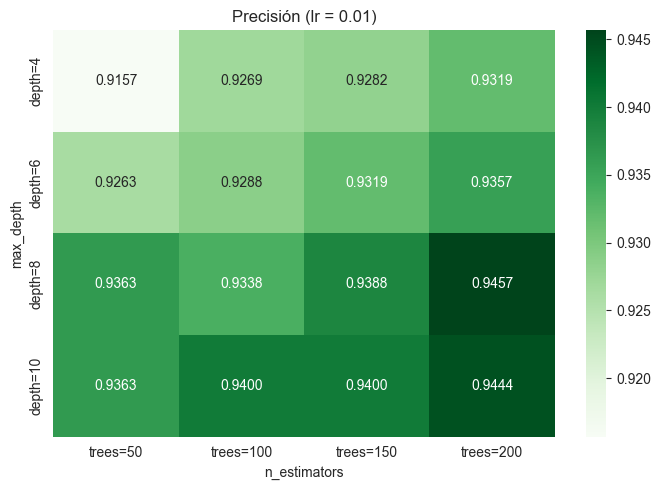

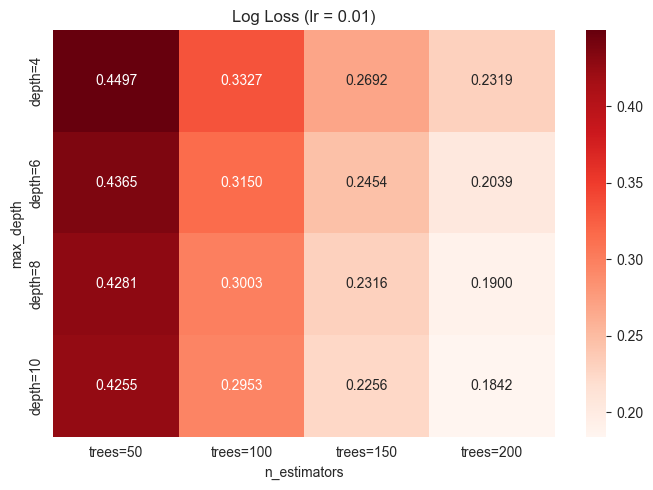

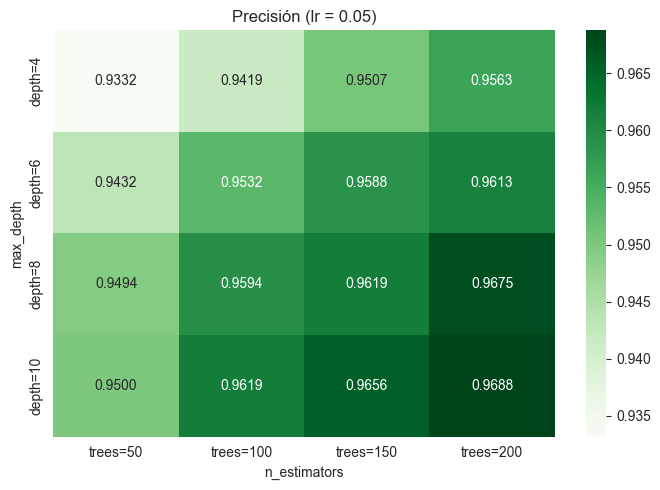

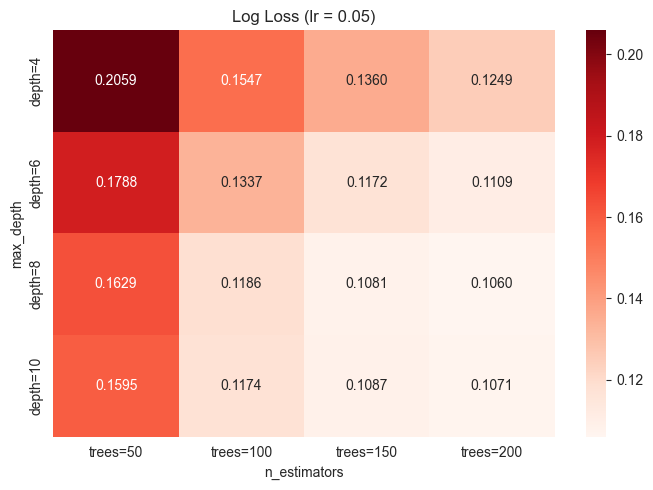

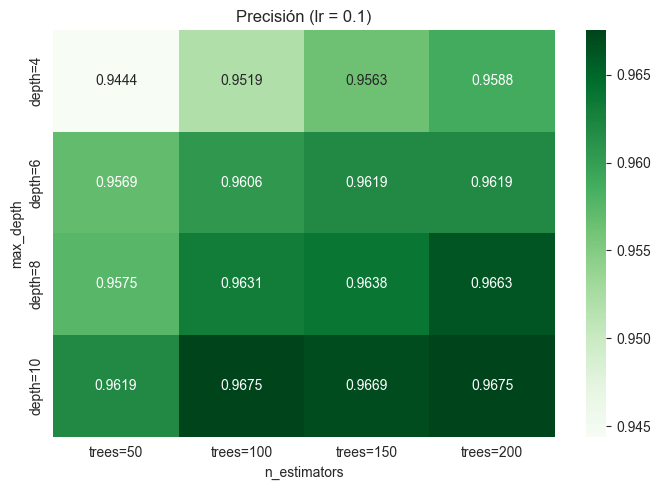

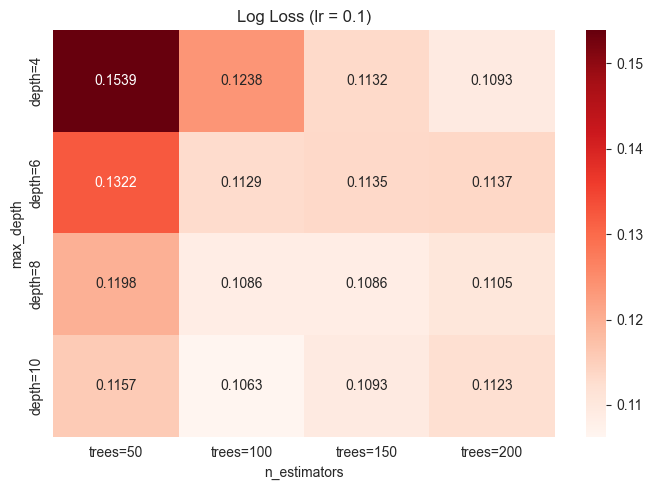

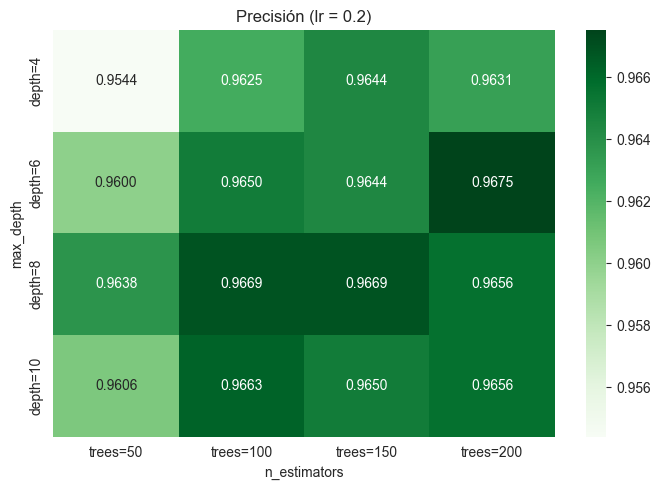

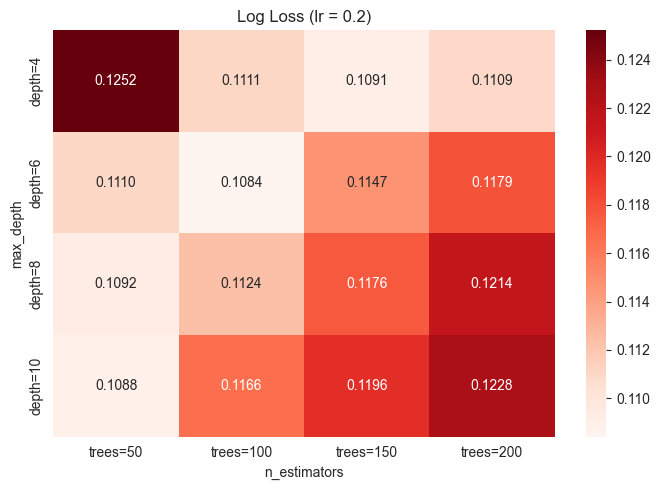

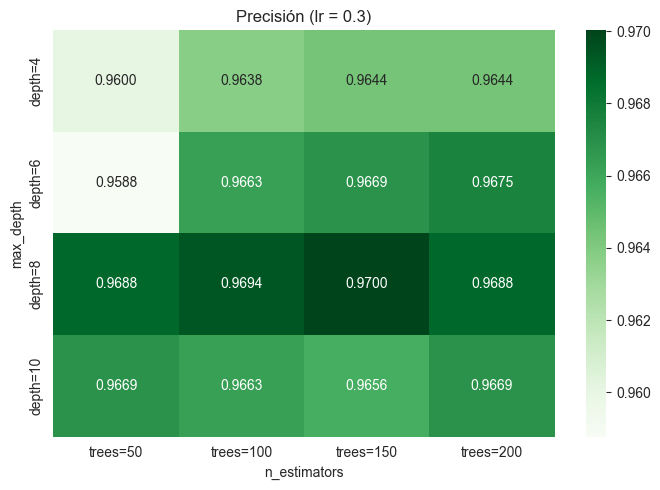

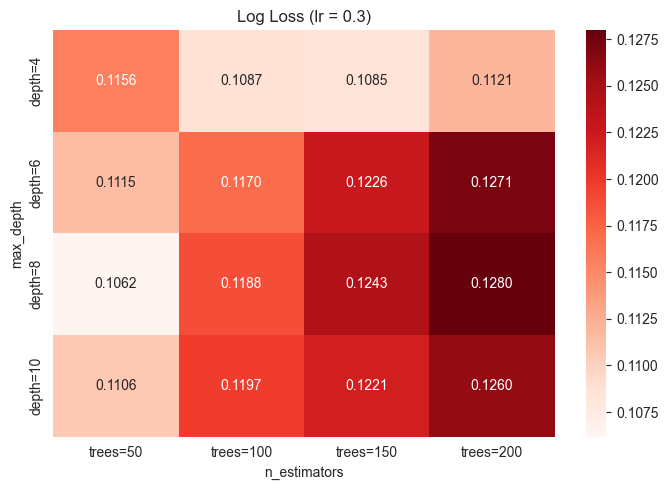

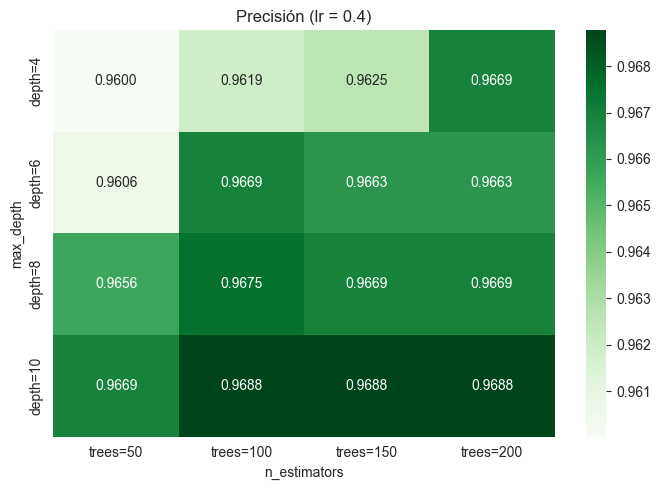

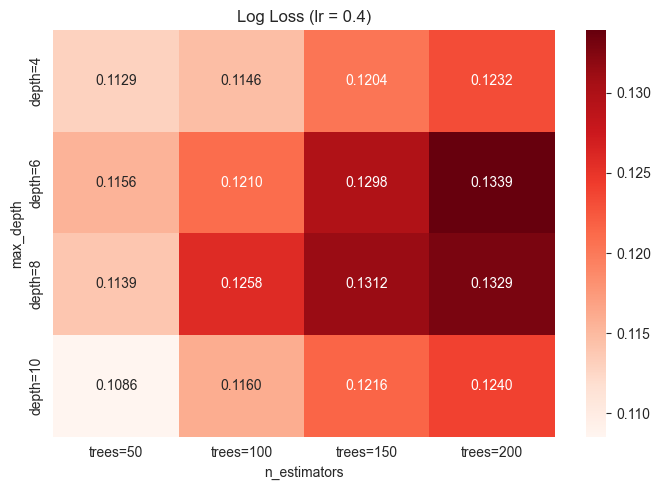

🔹 Mejor Accuracy: 0.97 con lr = 0.3 , depth = 8 , trees = 150
🔹 Mejor LogLoss : 0.106 con lr = 0.05 , depth = 8 , trees = 200


In [18]:
# 1. Cargar el dataset final
df = pd.read_csv("Data/URL_Train.csv")

# 2. Separar variables y objetivo
X = df.drop(columns=['status'])
y = df['status']

# 3. División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Parámetros a probar
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
depths = [4, 6, 8, 10]
trees = [50, 100, 150, 200]

# 5. Inicializar diccionarios para guardar resultado
acc_results = {}
loss_results = {}

# 6. Entrenamiento por combinación
for lr in learning_rates:
    acc_grid = []
    loss_grid = []
    for d in depths:
        acc_row = []
        loss_row = []
        for t in trees:
            model_url = XGBClassifier(
                learning_rate=lr,
                max_depth=d,
                n_estimators=t,
                use_label_encoder=False,
                eval_metric='logloss',
                verbosity=0,
                random_state=42
            )
            model_url.fit(X_train, y_train)
            y_pred = model_url.predict(X_test)
            y_proba = model_url.predict_proba(X_test)

            acc = accuracy_score(y_test, y_pred)
            loss = log_loss(y_test, y_proba)
            # Guarda las métricas
            acc_row.append(acc)
            loss_row.append(loss)
        # Agrega la fila
        acc_grid.append(acc_row)
        loss_grid.append(loss_row)

    # Convierte los resultados en un DF
    acc_results[f"lr={lr}"] = pd.DataFrame(
        acc_grid,
        index=[f"depth={d}" for d in depths],
        columns=[f"trees={t}" for t in trees]
    )

    loss_results[f"lr={lr}"] = pd.DataFrame(
        loss_grid,
        index=[f"depth={d}" for d in depths],
        columns=[f"trees={t}" for t in trees]
    )

# === 7. Mostrar resultados ===

    # Heatmap precisión
    plt.figure(figsize=(7, 5))
    sns.heatmap(acc_results[f"lr={lr}"], annot=True, fmt=".4f", cmap="Greens")
    plt.title(f"Precisión (lr = {lr})")
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()

    # Heatmap log loss
    plt.figure(figsize=(7, 5))
    sns.heatmap(loss_results[f"lr={lr}"], annot=True, fmt=".4f", cmap="Reds")
    plt.title(f"Log Loss (lr = {lr})")
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()

# === 8. Mostrar mejores combinaciones ===
mejor_acc = 0
mejor_params_acc = None
mejor_loss = float("inf")
mejor_params_loss = None

for lr in learning_rates:
    df_acc = acc_results[f"lr={lr}"]
    df_loss = loss_results[f"lr={lr}"]

    for i, d in enumerate(depths):
        for j, t in enumerate(trees):
            acc = df_acc.iloc[i, j]
            loss = df_loss.iloc[i, j]

            if acc > mejor_acc:
                mejor_acc = acc
                mejor_params_acc = (lr, d, t)

            if loss < mejor_loss:
                mejor_loss = loss
                mejor_params_loss = (lr, d, t)

print("🔹 Mejor Accuracy:", round(mejor_acc, 4), "con lr =", mejor_params_acc[0], ", depth =", mejor_params_acc[1], ", trees =", mejor_params_acc[2])
print("🔹 Mejor LogLoss :", round(mejor_loss, 4), "con lr =", mejor_params_loss[0], ", depth =", mejor_params_loss[1], ", trees =", mejor_params_loss[2])

### learning_rate = 0.2: permite un aprendizaje progresivo sin sobreajustar.

### max_depth = 10: capta relaciones complejas sin hacer el modelo muy costoso.

### n_estimators = 50: número óptimo de árboles para lograr alta precisión (95.88%) con buen tiempo de entrenamiento.

### eval_metric = 'logloss': adecuada para clasificación binaria y calibración de probabilidades.

### random_state = 42: garantiza reproducibilidad de los resultados.

In [19]:
# Cargar dataset
df = pd.read_csv("Data/URL_Train.csv")
X = df.drop(columns=["status"])
y = df["status"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model_url = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    random_state=42
)

# Entrenar y registrar resultados
model_url.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Predicciones
y_pred = model_url.predict(X_test)

# Métricas principales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, model_url.predict_proba(X_test)[:, 1])

# Mostrar resultados
print("=== Resultados del Modelo ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# Matriz de confusión y resumen
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))

=== Resultados del Modelo ===
Accuracy:  0.9675
Precision: 0.9591
Recall:    0.9760
F1 Score:  0.9675
ROC AUC:   0.9921

Matriz de Confusión:
[[776  33]
 [ 19 773]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9761    0.9592    0.9676       809
           1     0.9591    0.9760    0.9675       792

    accuracy                         0.9675      1601
   macro avg     0.9676    0.9676    0.9675      1601
weighted avg     0.9677    0.9675    0.9675      1601



# Validación del Modelo

In [22]:
# 1. Cargar nuevo dataset con URLs ya convertidas en features
ruta_nuevas_urls = "../Extraction/Data/dataset_procesado.csv"
df_nuevas = pd.read_csv(ruta_nuevas_urls)

# 2. Separar las columnas que no se deben usar en la predicción
X_nuevas = df_nuevas.drop(columns=['URL', 'Label'])

# 3. Predecir probabilidad de phishing
probs = model_url.predict_proba(X_nuevas)[:, 1]  # Probabilidad de clase 1 (phishing)

# 4. Ajustar el umbral manualmente
umbral = 0.5  # Puedes probar con 0.4, 0.5, 0.6, etc.
y_pred = (probs >= umbral).astype(int)

# 5. Añadir resultados al DataFrame
df_nuevas['prob_phishing'] = probs
df_nuevas['prediccion'] = y_pred
df_nuevas['prediccion_texto'] = df_nuevas['prediccion'].map({0: 'Legítimo', 1: 'Phishing'})

# 6. Guardar resultados si deseas
df_nuevas.to_csv('Data/urls_con_predicciones.csv', index=False)


In [23]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# 7. Convertir etiquetas reales
y_true = df_nuevas['Label']

# 8. Métricas
print("=== Resultados del Modelo en Nuevas URLs ===")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_true, probs):.4f}")

# 9. Matriz de confusión
matriz = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusión:")
print(matriz)

# 10. Reporte detallado
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred))

# Mostrar resultado textual para cada fila
print("\n=== Diagnóstico de cada URL ===")
for i in range(len(y_pred)):
    texto = "Phishing" if y_pred[i] == 1 else "Legítimo"
    print(f"→ URL: {df_nuevas.iloc[i]['URL']} → Predicción: {texto} (prob = {probs[i]:.4f})")

=== Resultados del Modelo en Nuevas URLs ===
Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   nan

Matriz de Confusión:
[[0 1]
 [0 0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0


=== Diagnóstico de cada URL ===
→ URL: http://signin.eday.co.uk.ws.edayisapi.dllsign.inusingsslpuseridcopartnerid2siteid.zdfxx949xyss1pnbh0soabfdzgdh2kppnu.reippl.com/ → Predicción: Phishing (prob = 0.9913)


C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\skle

### Se selecciona el umbral de "0.5" porque logra el mejor equilibrio en la validación, tanto en la precisión (71.67%) y recall (91.49%), lo que permite detectar la mayoría de URLs phishing sin generar demasiados falsos positivos. Es ideal para un entorno de seguridad donde es más importante no dejar pasar amenazas que evitar alertas innecesarias.

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Variables necesarias:
y_true = df_nuevas['Label']
probs = df_nuevas['prob_phishing']

# Lista de umbrales a evaluar
umbrales = [0.3, 0.4, 0.5, 0.6, 0.7]

print("=== Evaluación de diferentes umbrales ===\n")
for umbral in umbrales:
    y_pred = (probs >= umbral).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Umbral: {umbral}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


=== Evaluación de diferentes umbrales ===

Umbral: 0.3
  Accuracy : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000

Umbral: 0.4
  Accuracy : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000

Umbral: 0.5
  Accuracy : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000

Umbral: 0.6
  Accuracy : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000

Umbral: 0.7
  Accuracy : 0.0000
  Precision: 0.0000
  Recall   : 0.0000
  F1 Score : 0.0000



C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [25]:
joblib.dump(model_url, "mode_detection_url.pkl")
print("Exported Model")

Exported Model
